In [1]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss_DTW, STR_Loss_Identity
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length, disable=True):  
        data, target = data.squeeze(0).to(device), target.squeeze(0).to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss, dtw_loss, sos_loss, eos_loss  = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[-1]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item(), dtw_loss.item(), sos_loss.item(), eos_loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, plot=1):
    train_losses, dtw_losses, sos_losses, eos_losses = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        if epoch % plot == 0: 
            print('=====================================================================\n')
            if len(train_losses) > 0: print(f'Epoch: {epoch} | Loss: {train_losses[-1]}')
            visualize_progress(model, device, train_loader, epoch)
        loss, dtw_loss, sos_loss, eos_loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        scheduler.step()

        train_losses.append(loss)
        dtw_losses.append(dtw_loss)
        sos_losses.append(sos_loss)
        eos_losses.append(eos_loss)

        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses, dtw_losses, sos_losses, eos_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 75
batch_size = 16 # Archibald it is 32
checkpoint_interval = 5
learning_rate = 0.001
lr_decay = 0.97

print('Using device:', device)

Using device: cuda


In [5]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, max_allowed_width=250)
dataloader = DataLoader(dataset, shuffle=True)

Preprocessing data: 100%|██████████| 2373/2373 [00:19<00:00, 124.06it/s]


In [6]:
# For singluar image
# idx = 14000
# dataloader = [(dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0))]

In [7]:
# Model
model = STR_Model_Longer_1024(relative_coords=False).to(device)
# set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss_DTW(sos_weight=5)

  0%|          | 0/75 [00:00<?, ?it/s]

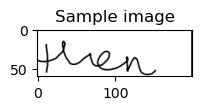

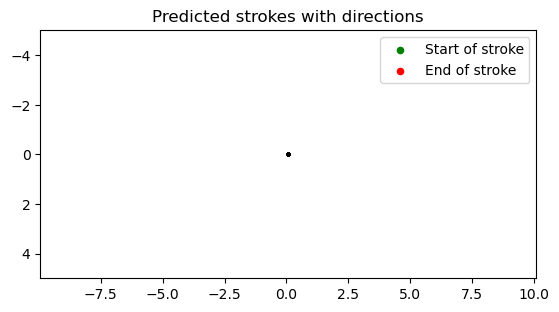

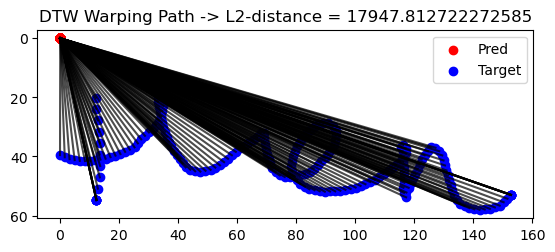

   Batch: 0    | Width: 112 | Loss: 39.0719
   Batch: 100  | Width: 108 | Loss: 17.7555
   Batch: 200  | Width: 114 | Loss: 15.8124
   Batch: 300  | Width: 48  | Loss: 9.8011
   Batch: 400  | Width: 190 | Loss: 23.4853
   Batch: 500  | Width: 86  | Loss: 10.5953
   Batch: 600  | Width: 118 | Loss: 9.1664
   Batch: 700  | Width: 184 | Loss: 15.6539
   Batch: 800  | Width: 166 | Loss: 12.8646
   Batch: 900  | Width: 58  | Loss: 6.4221
   Batch: 1000 | Width: 86  | Loss: 7.9054
   Batch: 1100 | Width: 168 | Loss: 10.5300
   Batch: 1200 | Width: 158 | Loss: 9.0699
   Batch: 1300 | Width: 64  | Loss: 7.3038
   Batch: 1400 | Width: 102 | Loss: 7.0681
   Batch: 1500 | Width: 214 | Loss: 12.9922
   Batch: 1600 | Width: 62  | Loss: 6.8656
   Batch: 1700 | Width: 74  | Loss: 6.8931
   Batch: 1800 | Width: 68  | Loss: 7.4700
   Batch: 1900 | Width: 84  | Loss: 6.4342
   Batch: 2000 | Width: 124 | Loss: 6.8860
   Batch: 2100 | Width: 132 | Loss: 7.5085
   Batch: 2200 | Width: 138 | Loss: 7.2610
  

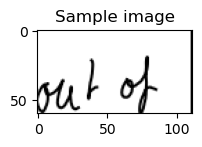

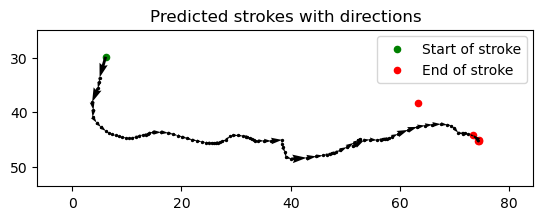

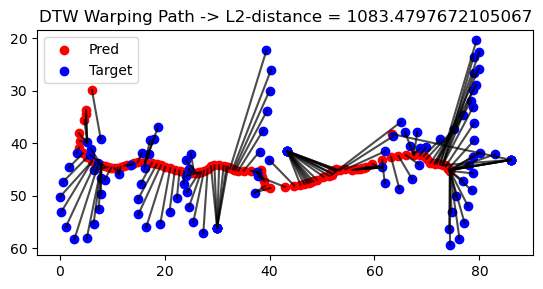

   Batch: 0    | Width: 72  | Loss: 6.4969
   Batch: 100  | Width: 174 | Loss: 8.3945
   Batch: 200  | Width: 200 | Loss: 8.5125
   Batch: 300  | Width: 78  | Loss: 6.9557


KeyboardInterrupt: 

In [8]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=1)

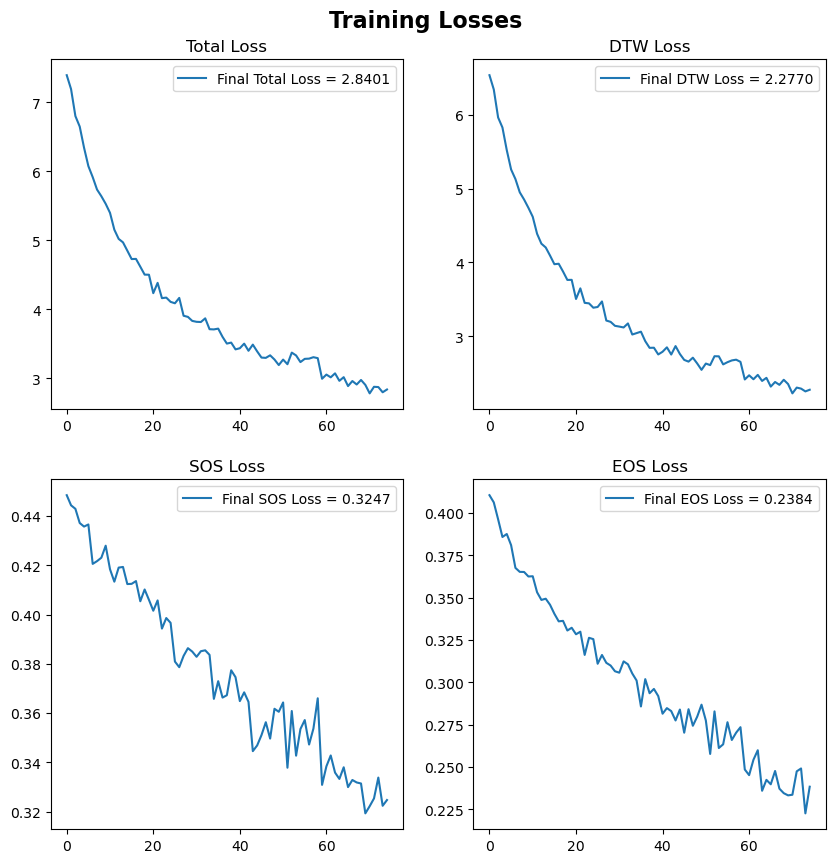

In [ ]:
plot_losses(losses)